# MRI reconstruction from multicoil data

In [1]:
from __future__ import print_function
import matplotlib.pyplot as plt
#%matplotlib notebook

import os
import sigpy.mri as mr

import sigpy as sp
import sigpy.mri as mr
from os import listdir
from os.path import isfile, join

import warnings
warnings.filterwarnings('ignore')

from include import *

from PIL import Image
import PIL
import h5py
#from skimage.metrics import structural_similarity as ssim
from common.evaluate import *
from pytorch_msssim import ms_ssim
import pickle
from common.subsample import MaskFunc

from DIP_UNET_models.unet_and_tv.train_unet import UnetMRIModel

import numpy as np
import torch
import torch.optim
from torch.autograd import Variable
#from models import *
#from utils.denoising_utils import *

# from facebook MRI
#import transforms
from include import transforms as transform

GPU = True
if GPU == True:
    torch.backends.cudnn.enabled = True
    torch.backends.cudnn.benchmark = True
    dtype = torch.cuda.FloatTensor
    #os.environ['CUDA_VISIBLE_DEVICES'] = '0'
    gpu = 0
    torch.cuda.set_device(gpu)
    print("num GPUs",torch.cuda.device_count())
else:
    dtype = torch.FloatTensor

num GPUs 3


# Loading MRI measurement

In [2]:
### Get image from the validation set
filename = '/hdd/multicoil_val/file1001184.h5' # without fat suppression
#filename = '/hdd/multicoil_val/file1001090.h5' # with fat suppression


f = h5py.File(filename, 'r') # contains a kspace measurement f['kspace'] and rss reconstruction f['reconstruction_rss']
print("Kspace shape (number slices, number coils, x, y): ", f['kspace'].shape)

# which slice to consider in the following
slicenu = f["kspace"].shape[0]//2

slice_ksp = f['kspace'][slicenu]

slice_ksp_torchtensor = transform.to_tensor(slice_ksp)      # Convert from numpy array to pytorch tensor
slice_image = transform.ifft2(slice_ksp_torchtensor)           # Apply Inverse Fourier Transform to get the complex image
slice_image_abs = transform.complex_abs(slice_image)   # Compute absolute value to get a real image

Kspace shape (number slices, number coils, x, y):  (37, 15, 640, 368)


### ConvDecoder setup

In [3]:
numit = 25000
LR = 0.008

In [4]:
output_depth = slice_ksp.shape[0]*2
out_size = slice_ksp.shape[1:]

num_channels = 160 #256
num_layers = 7
strides = [1]*(num_layers-1)
in_size = [8,4]
kernel_size = 3
parnet = convdecoder(out_size,in_size,output_depth,
                     num_layers,strides,num_channels, act_fun = nn.ReLU(),
                     skips=False,need_sigmoid=False,bias=False, need_last = True,
                     kernel_size=kernel_size,upsample_mode="nearest").type(dtype)
print(num_param(parnet))
parnet

[(17, 9), (35, 19), (72, 39), (149, 82), (309, 174), (640, 368)]
1619840


conv_model(
  (act_fun): ReLU()
  (net1): Sequential(
    (1): Upsample(size=(17, 9), mode=nearest)
    (2): Conv2d(160, 160, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (3): ReLU()
    (4): BatchNorm2d(160, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): Upsample(size=(35, 19), mode=nearest)
    (6): Conv2d(160, 160, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (7): ReLU()
    (8): BatchNorm2d(160, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): Upsample(size=(72, 39), mode=nearest)
    (10): Conv2d(160, 160, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (11): ReLU()
    (12): BatchNorm2d(160, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (13): Upsample(size=(149, 82), mode=nearest)
    (14): Conv2d(160, 160, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (15): ReLU()
    (16): BatchNorm2d(160, eps=1e-05, momentum=0.1, affine=Tru

In [5]:
### fixing the scaling (note that it can be done using the under-sampled kspace as well, but we do it using the full kspace)
scale_out = 1
scaling_factor,ni = get_scale_factor(parnet,
                                   num_channels,
                                   in_size,
                                   slice_ksp,
                                   scale_out=scale_out)

In [6]:
scaling_factor

34773.828317747044

In [7]:
slice_ksp_torchtensor = slice_ksp_torchtensor * scaling_factor
slice_ksp = slice_ksp * scaling_factor

### Undersampling the k-space

In [8]:
try: # if the file already has a mask
    temp = np.array([1 if e else 0 for e in f["mask"]])
    temp = temp[np.newaxis].T
    temp = np.array([[temp]])
    mask = transform.to_tensor(temp).type(dtype).detach().cpu()
except: # if we need to create a mask
    desired_factor = 4 # desired under-sampling factor
    undersampling_factor = 0
    tolerance = 0.03
    while undersampling_factor < desired_factor - tolerance or undersampling_factor > desired_factor + tolerance:
        mask_func = MaskFunc(center_fractions=[0.07], accelerations=[desired_factor])  # Create the mask function object
        masked_kspace, mask = transform.apply_mask(slice_ksp_torchtensor, mask_func=mask_func)   # Apply the mask to k-space
        mask1d = var_to_np(mask)[0,:,0]
        undersampling_factor = len(mask1d) / sum(mask1d)

mask1d = var_to_np(mask)[0,:,0]

# The provided mask and data have last dim of 368, but the actual data is smaller.
# To prevent forcing the network to learn outside the data region, we force the mask to 0 there.
mask1d[:mask1d.shape[-1]//2-160] = 0 
mask1d[mask1d.shape[-1]//2+160:] =0
mask2d = np.repeat(mask1d[None,:], slice_ksp.shape[1], axis=0).astype(int) # Turning 1D Mask into 2D that matches data dimensions
mask2d = np.pad(mask2d,((0,),((slice_ksp.shape[-1]-mask2d.shape[-1])//2,)),mode='constant') # Zero padding to make sure dimensions match up
mask = transform.to_tensor( np.array( [[mask2d[0][np.newaxis].T]] ) ).type(dtype).detach().cpu()

In [9]:
print("under-sampling factor",len(mask1d)/sum(mask1d))

under-sampling factor 4.380952380952381


In [10]:
masked_kspace, mask = transform.apply_mask(slice_ksp_torchtensor, mask = mask)
unders_measurement = np_to_var( masked_kspace.data.cpu().numpy() ).type(dtype)
sampled_image2 = transform.ifft2(masked_kspace)

In [11]:
##### input normalization for U-net
# Crop input image to given resolution if larger
smallest_width = min(320, sampled_image2.shape[-2])
smallest_height = min(320, sampled_image2.shape[-3])

crop_size = (smallest_height, smallest_width)
sampled_image = transform.complex_center_crop(sampled_image2, crop_size)
# Absolute value
sampled_image = transform.complex_abs(sampled_image)
# Apply Root-Sum-of-Squares if multicoil data
sampled_image = transform.root_sum_of_squares(sampled_image)
# Normalize input
sampled_image, mean, std = transform.normalize_instance(sampled_image, eps=1e-11)
sampled_image = sampled_image.clamp(-6, 6)

## Least-squares estimate from full kspace measurement

The least-squares estimate is obtained from the full kspace measurement by first computing the least estimate for each coil slice and then computing an estimate of the final image via the root sum of squares algorithm:
$$
x_{result} = \sqrt{\sum_{i=1}^n x_i }.
$$
Here, $x_i$ is the $i$-th entry of the image.

In [12]:
measurement = ksp2measurement(slice_ksp).type(dtype)

In [13]:
# reconstruct from full kspace measurement with build-in function
slice_image_rss = transform.root_sum_of_squares(slice_image_abs, dim=0)

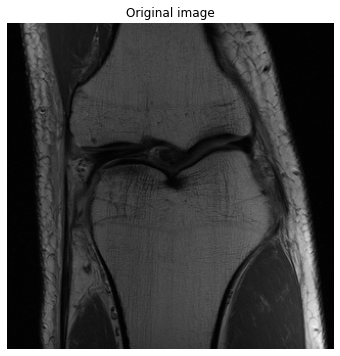

In [14]:
lsimg = lsreconstruction(measurement)
lsrec = crop_center2( root_sum_of_squares2(var_to_np(lsimg)) , 320,320)

fig = plt.figure(figsize = (6,6)) # create a 6 x 6 figure 
ax1 = fig.add_subplot(111)
ax1.imshow(lsrec,cmap='gray')
ax1.set_title('Original image')
ax1.axis('off')
plt.show()

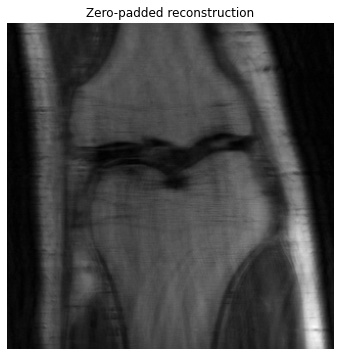

In [15]:
fig = plt.figure(figsize = (6,6)) 
ax1 = fig.add_subplot(111)
ax1.imshow(sampled_image,cmap='gray')
ax1.set_title('Zero-padded reconstruction')
ax1.axis('off')
plt.show()

### Fitting ConvDecoder to the under-sampled k-space

In [16]:
num_param(parnet)

1619840

In [17]:
out = []
for img in sampled_image2:
    out += [ img[:,:,0].numpy() , img[:,:,1].numpy() ]
lsest = torch.tensor(np.array([out]))

In [18]:
scale_out=1

In [19]:
scale_out,sover,pover,norm_ratio,par_mse_n, par_mse_t, parni, parnet = fit( in_size = in_size,
                                                                num_channels=[num_channels]*(num_layers-1),
                                                                num_iter=numit,
                                                                LR=LR,
                                                                mask = mask2d,
                                                                apply_f = forwardm,
                                                                img_noisy_var=unders_measurement,
                                                                net=parnet,
                                                                upsample_mode="free",
                                                                img_clean_var=Variable(lsest).type(dtype),
                                                                lsimg = lsimg,
                                                                find_best=True,
                                                                loss_type="MSE",
                                                                scale_out=scale_out,
                                                                net_input = ni,
                                                                OPTIMIZER = "adam"
                                                                          )

input provided
optimize with adam 0.008


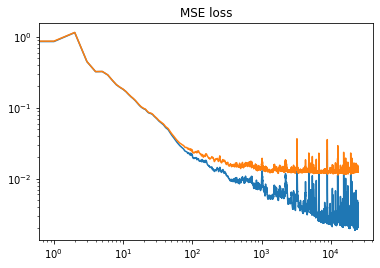

In [20]:
plt.loglog(par_mse_n)
plt.loglog(par_mse_t)
plt.title("MSE loss")
plt.show()

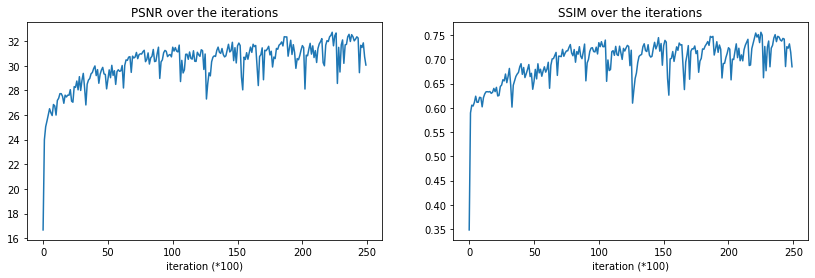

In [21]:
fig = plt.figure(figsize = (14,4)) # create a 5 x 5 figure 
    
ax1 = fig.add_subplot(121)
ax1.plot(pover)
ax1.set_title('PSNR over the iterations')
ax1.set_xlabel("iteration (*100)")

ax2 = fig.add_subplot(122)
ax2.plot(sover)
ax2.set_title( "SSIM over the iterations" )
ax2.set_xlabel("iteration (*100)")

plt.show()

### Get the network output and pass it through  the data consistency term

In [22]:
img = parnet(parni.type(dtype))
s = img.shape
ns = int(s[1]/2) # number of slices
fimg = Variable( torch.zeros( (s[0],ns,s[2],s[3],2 ) ) ).type(dtype)
for i in range(ns):
    fimg[0,i,:,:,0] = img[0,2*i,:,:]
    fimg[0,i,:,:,1] = img[0,2*i+1,:,:]
Fimg = transform.fft2(fimg) # dim: (1,num_slices,x,y,2)
# ksp has dim: (num_slices,x,y)
meas = ksp2measurement(slice_ksp) # dim: (1,num_slices,x,y,2)
mask = torch.from_numpy(np.array(mask1d, dtype=np.uint8))
ksp_dc = Fimg.clone()
ksp_dc = ksp_dc.detach().cpu()
ksp_dc[:,:,:,mask==1,:] = meas[:,:,:,mask==1,:] # after data consistency block

img_dc = transform.ifft2(ksp_dc)[0]
out = []
for img in img_dc.detach().cpu():
    out += [ img[:,:,0].numpy() , img[:,:,1].numpy() ]

par_out_chs = np.array(out)
#par_out_chs = parnet( parni.type(dtype),scale_out=scale_out ).data.cpu().numpy()[0]
par_out_imgs = channels2imgs(par_out_chs)

prec = crop_center2(root_sum_of_squares2(par_out_imgs),320,320)

In [23]:
# normalization before computing the scores
im2 = prec.copy()
im1 = f["reconstruction_rss"][slicenu]
im1 = (im1-im1.mean()) / im1.std()
im1 *= im2.std()
im1 += im2.mean()

In [24]:
vif_ = vifp_mscale(im1,im2,sigma_nsq=im1.mean())

In [25]:
ssim_ = ssim(np.array([im1]), np.array([im2]))
psnr_ = psnr(np.array([im1]),np.array([im2]))

dt = torch.FloatTensor
im11 = torch.from_numpy(np.array([[im1]])).type(dt)
im22 = torch.from_numpy(np.array([[im2]])).type(dt)
ms_ssim_ = ms_ssim(im11, im22,data_range=im22.max()).data.cpu().numpy()[np.newaxis][0]

### Loading U-net to get the output for this image

In [26]:
class args():
    def __init__(self):
        self.num_pools = 4
        self.drop_prob = 0
        self.num_chans = 32
args = args()
umdl = UnetMRIModel(args)
umdl.cuda(gpu);

In [27]:
checkpoint = torch.load('UNET_trained/epoch=49.ckpt', map_location='cpu')
umdl.load_state_dict(checkpoint['state_dict'])

<All keys matched successfully>

In [28]:
unet_out = umdl( torch.from_numpy(np.array([sampled_image.data.cpu().numpy()])).type(dtype) )
unet_out_np = unet_out.data.cpu().numpy()[0]

In [29]:
orig = f["reconstruction_rss"][slicenu]
orig = transforms.to_tensor(orig)
orig = transforms.center_crop(orig, (320,320))
orig = transforms.normalize(orig, mean, std, eps=1e-11)
#orig = torch.from_numpy(orig)
orig = orig.clamp(-6, 6)
orig = orig.data.cpu().numpy()

##### balance the dynamic range for score computation #####
mean = mean.data.cpu().numpy()[np.newaxis][0]
std = std.data.cpu().numpy()[np.newaxis][0]

In [30]:
##### scores ######
im1_unet = orig*std+mean
im2_unet = unet_out_np*std+mean
im1_unet = (im1_unet-im1_unet.mean()) / im1_unet.std()
im1_unet *= im2_unet.std()
im1_unet += im2_unet.mean()

vif_unet = vifp_mscale(im1_unet,im2_unet,sigma_nsq=im1_unet.mean())

ssim_unet = ssim(np.array([im1_unet]),np.array([im2_unet]))
psnr_unet = psnr(np.array([im1_unet]),np.array([im2_unet]))
dt = torch.FloatTensor
ms_ssim_unet = ms_ssim(torch.tensor([[im1_unet]]).type(dt), torch.tensor([[im2_unet]]).type(dt), data_range=im1_unet.max())

### Visualization

ConvDecoder --> VIF: 0.83, MS-SSIM: 0.97, SSIM: 0.88, PSNR: 34.57 
U-net       --> VIF: 0.86, MS-SSIM: 0.97, SSIM: 0.91, PSNR: 35.34 


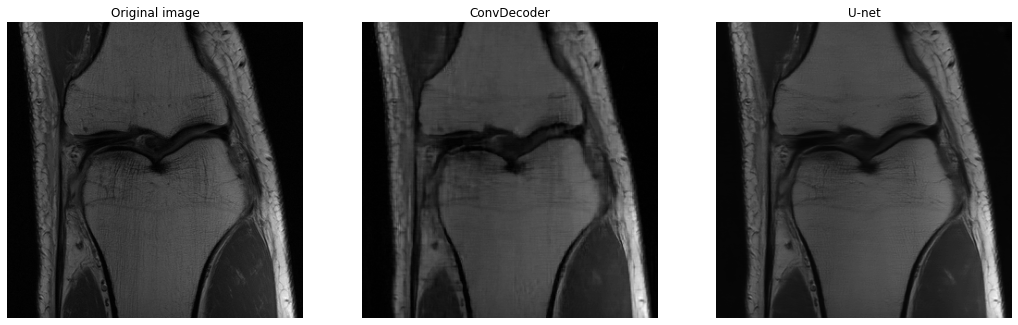

In [31]:
fig = plt.figure(figsize = (18,16)) # create a 5 x 5 figure 
    
ax1 = fig.add_subplot(131)
ax1.imshow(orig,cmap='gray')
ax1.set_title('Original image')
ax1.axis('off')

ax2 = fig.add_subplot(132)
ax2.imshow(prec,cmap='gray')
ax2.set_title( "ConvDecoder") 
ax2.axis('off') 

ax3 = fig.add_subplot(133)
ax3.imshow(im2_unet,cmap='gray')
ax3.set_title( "U-net" ) 
ax3.axis('off') 

print("ConvDecoder --> VIF: %.2f, MS-SSIM: %.2f, SSIM: %.2f, PSNR: %.2f " % (vif_,ms_ssim_,ssim_,psnr_))
print("U-net       --> VIF: %.2f, MS-SSIM: %.2f, SSIM: %.2f, PSNR: %.2f " % (vif_unet,ms_ssim_unet,ssim_unet,psnr_unet))

plt.show()